# Building Variational AutoEncoders (VAE) for generating genotypes
**Marcin Kierczak** 22-03-2023

### Synopsis

Here, we will re-visit our good old HapMap example from the previous lab. Now, we are not only interested in finding good 2D representation of our multi-dimensional genetoc data. We also want to be able to generate new data, here new artificial genotypes, by just providing coordinates on the 2D embedding plane. Pretty cool, huh? Well, let's see if and how it works...

### Disclaimer

This lab is very new and highly exploratory. There are not many questions or code gaps to fill in for you. Instead, I want you to wrap your mind around how a VAE works and how to implement it. Please, feel free to play around with the code and enjoy the results!

### Initial steps

All initial steps are similar to what you already know from the other lab. 

* load necessary Python modules,
* load genotypes and phenotypes -- here you will have to adjust path,
* build dictionary of populations, I also add a test population of Neverlanders that we will create later,
* scale the data,
* split your data into training and test set, put test set asides


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

2023-03-22 14:32:32.386731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
geno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_phenos.csv", header=0, index_col=0)

print(geno.iloc[0:5, 0:5])
print(pheno.iloc[0:5, 0:5])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341
NA19919         2           1           0           1           1
NA19916         1           0           0           1           1
NA19835         0           0           1           1           0
NA20282         1           1           0           1           0
NA19703         0           0           0           0           1
              id  sex   FID      dad      mom
NA19919  NA19919    1  2427  NA19908  NA19909
NA19916  NA19916    1  2431        0        0
NA19835  NA19835    0  2424        0        0
NA20282  NA20282    0  2469        0        0
NA19703  NA19703    1  2368        0        0


In [4]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria',
            'TST':'Test population in Neverland'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2.iloc[0:2, :]

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA


In [5]:
# Scaling 
# We need to scale our counts data so that it is bound between 0 and 1. 
# Now, the AA homozygotes will be coded as 0, heterozygotes as 0.5 and aa homozygotes as 1. 

geno_data = geno / 2
print(geno_data.iloc[0:5, 0:10])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919       1.0         0.5         0.0         0.5         0.5        0.0   
NA19916       0.5         0.0         0.0         0.5         0.5        0.0   
NA19835       0.0         0.0         0.5         0.5         0.0        0.5   
NA20282       0.5         0.5         0.0         0.5         0.0        0.0   
NA19703       0.0         0.0         0.0         0.0         0.5        0.5   

         rs882529  rs3885937  rs537330  rs9372090  
NA19919       0.0        0.5       0.5        0.5  
NA19916       0.5        0.5       1.0        0.5  
NA19835       0.0        1.0       1.0        0.5  
NA20282       0.0        0.0       0.5        0.5  
NA19703       0.0        0.0       0.0        1.0  


In [6]:
# Randomly split into the training and the test set
data = geno_data
train = data.sample(frac = 0.9, random_state = 42) 
test = data.drop(train.index)
train_pheno = pheno2[pheno2.index.isin(train.index)]
test_pheno = pheno2.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Number of individuals:", data.shape[0])
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Number of individuals: 1184
	 - training set: (1066, 5000)
	 - test set: (118, 5000)


## Our VAE model

### Custom sampling layer

As you, hopefully, remember from the lecture, VAEs need a so-called 'sampling layer' that performs sampling operation from two outputs from the previous layer: z_means and z_log_sigma. Here, we need to implement this layer ourselves as it is not a part of Keras (at least it has not been at the time when I started writing the code).

### Encoder

Next, we will build an encoder remembering that there are two extra layers: one that will learn means, the other one that will learn variances (std. devs) of out distributions from which the custom sampling layer will sample.

### Decoder

There is nothing special to the decoder part as compared to a vanilla autoencoder.

<class 'numpy.ndarray'>


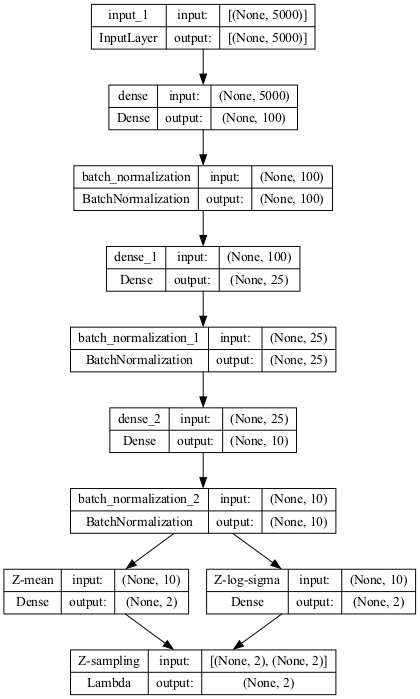

In [7]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

# Custom sampling layer
  
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0, stddev=.1)
    return z_mean + K.exp(z_log_sigma) * epsilon
  
# Encoder
inputs = keras.Input(shape=(original_dim,))
outputs = inputs
h = layers.Dense(units = 100, activation = 'relu')(inputs)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 10, activation = 'relu')(h)
h = layers.BatchNormalization()(h)
# Bottleneck
z_mean = layers.Dense(latent_dim, name = 'Z-mean')(h)
z_log_sigma = layers.Dense(latent_dim, name = 'Z-log-sigma')(h)
z = layers.Lambda(sampling, name = 'Z-sampling')([z_mean, z_log_sigma])
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(units = 10, activation = 'relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 25, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 100, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(original_dim, activation='sigmoid', name='decoder-output')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

plot_model(encoder, show_shapes=True, show_layer_names = True, dpi=70, to_file="enc_model.png")

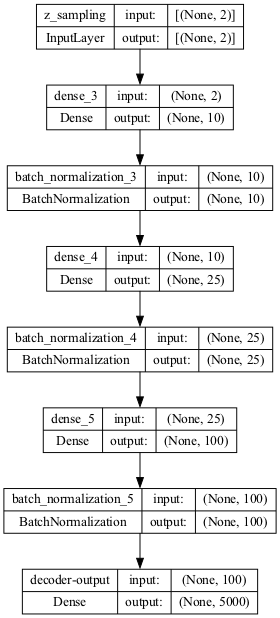

In [8]:
plot_model(decoder, show_shapes=True, show_layer_names = True, dpi=70, to_file="dec_model.png")

## Custom loss

We also need to provide our model with custom loss function that contains Kullback-Liebler divergence component.
After this, we are ready to train the model.

In [9]:
# KL divergence loss compares the encoded latent distribution Z 
# with standard Normal distribution and penalizes if it's too different

reconstruction_loss = original_dim * keras.losses.mse(inputs, outputs)  # use MSE
KL_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(reconstruction_loss + KL_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

hp_epochs = 30

vae.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = 32,
        shuffle = True,
        validation_split = 0.2)

Epoch 1/30
27/27 [==============================] - 3s 19ms/step - loss: 919.8769 - val_loss: 905.4250
Epoch 2/30
27/27 [==============================] - 0s 9ms/step - loss: 860.7607 - val_loss: 832.7147
Epoch 3/30
27/27 [==============================] - 0s 8ms/step - loss: 729.4379 - val_loss: 659.5263
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 542.9067 - val_loss: 478.9183
Epoch 5/30
27/27 [==============================] - 0s 8ms/step - loss: 407.5773 - val_loss: 384.3117
Epoch 6/30
27/27 [==============================] - 0s 8ms/step - loss: 349.7852 - val_loss: 349.3767
Epoch 7/30
27/27 [==============================] - 0s 8ms/step - loss: 330.7896 - val_loss: 335.9944
Epoch 8/30
27/27 [==============================] - 0s 8ms/step - loss: 323.8181 - val_loss: 330.9280
Epoch 9/30
27/27 [==============================] - 0s 9ms/step - loss: 321.4835 - val_loss: 327.4609
Epoch 10/30
27/27 [==============================] - 0s 8ms/step - loss: 320.5427

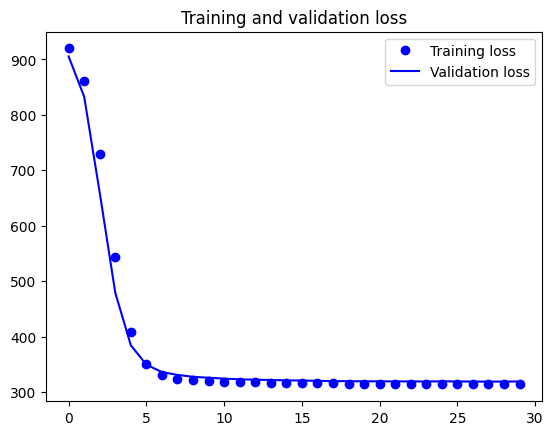

In [10]:
loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Embeddings

Now, let's look at our embeddings. Are they good enough?

37/37 [==============================] - 0s 2ms/step


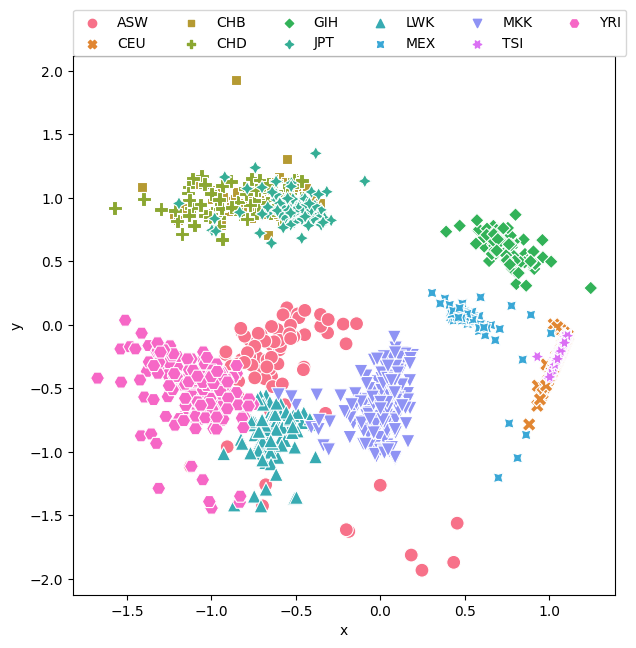

In [11]:
x_encoded = encoder.predict(geno_data, batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop = pheno['population']
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=1, ncol=6)
plt.show()

## Go generative!

Now, the fun begins. We can go generative. Let's pick some coords on our latent space above, say [-0.1, -0.25] and
randomly sample 10 individuals that are close to these. This will be our new artificial population of Neverlanders.

In [12]:
N_ind = 10
center = [-.1, -0.25] 
cx = K.random_normal(shape = [N_ind], mean = center[0], stddev = 0.01)
cy = K.random_normal(shape = [N_ind], mean = center[1], stddev = 0.01)
z_sample = np.vstack((cx, cy)).T
tf.print(z_sample)

array([[-0.11814965, -0.26366794],
       [-0.10482851, -0.23849523],
       [-0.1203045 , -0.26064903],
       [-0.09245164, -0.25851083],
       [-0.09437246, -0.25518197],
       [-0.11039776, -0.250159  ],
       [-0.09549136, -0.25844005],
       [-0.08111048, -0.23035426],
       [-0.08291602, -0.25011444],
       [-0.10088515, -0.2555667 ]], dtype=float32)


We now use our decoder to translate these new datapoints to genotypes. 

In [13]:
decoded = decoder.predict(z_sample)
print(decoded)
new_geno = np.zeros(shape = decoded.shape)
new_geno[decoded <= 0.33] = 0
new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 0.5
new_geno[decoded > 0.66] = 1
print(new_geno)

1/1 [==============================] - 0s 73ms/step
[[0.31874272 0.23940416 0.19284135 ... 0.38936713 0.2823485  0.10647902]
 [0.31062818 0.23885942 0.19048287 ... 0.38411888 0.2792323  0.10441055]
 [0.31694302 0.23714474 0.19268824 ... 0.38805953 0.2812334  0.10641947]
 ...
 [0.31295606 0.2510074  0.1905953  ... 0.38564444 0.28223228 0.10399341]
 [0.3201654  0.25537366 0.19254282 ... 0.3907968  0.28613168 0.10514798]
 [0.31935263 0.24737029 0.19248825 ... 0.38996285 0.28440797 0.10587857]]
[[0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]]


Let's see where will the articial genotypes end up if we feed them to our encoder along with the original data.

38/38 [==============================] - 0s 2ms/step


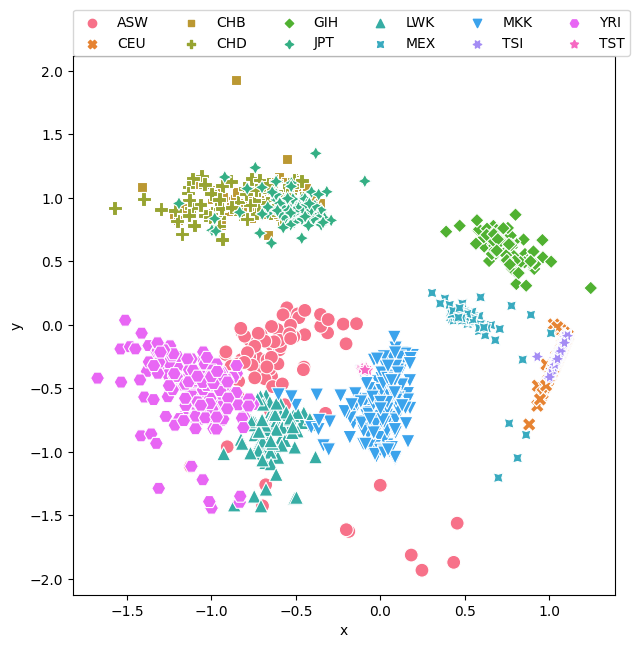

In [14]:
x_encoded = encoder.predict(np.row_stack((geno_data, decoded)), batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
pop = pd.concat(pop_list) 
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=1, ncol=6)
plt.show()

Not bad! Maybe they do not end up super exactly where our center point was (I am not sure why the x coord sometimes is a bit shifted) but they are more or less where we wanted them to be!

## PCA validation

Finally, let's see where classical PCA would place our Neverlanders.

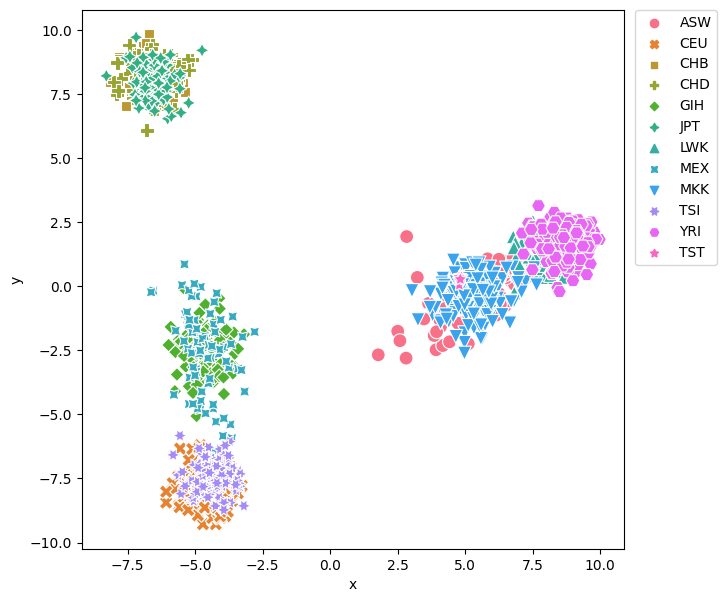

In [15]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(np.row_stack((geno_data, new_geno)) * 2)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7,7))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=1)
plt.show()